<a href="https://colab.research.google.com/github/dorrabennour/Finance-research-project/blob/main/PRR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estimation de la volatilité implicite et du prix des options**


In [ ]:
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf
from sympy import init_printing

## Modele de Black & scholes

In [ ]:
def black_scholes_call_div(S, K, T, r,  sigma):
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call

In [ ]:
def g(S, K, T, r,  sigma,v):
    return(black_scholes_call_div(S, K, T, r,  sigma)-v)

In [ ]:
def densité(x):
    return(np.exp(-x**2)/(np.sqrt(2*3.14)))

In [ ]:
#Dérivée de la densité
def gp(S, K, T, r,  sigma):  
     d1 = ( np.log(S / K)  + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
     d2 = d1-sigma*np.sqrt(T)
     c=S*np.sqrt(T)*densité(d1)
     return(c)

## Méthode de Newton

In [ ]:
def newton(f,Df,x0,epsilon,max_iter,S, K, T, r,  sigma,v):
   
    xn = x0
    for n in range(0,max_iter):
        fxn = f(S, K, T, r,xn,v)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = Df(S, K, T, r,xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None



In [ ]:
S=100
K=105
T=1
r=0.01
sigma=0.1
v=10
x0=0.1
v=black_scholes_call_div(S, K, T, r,  sigma)
sigma1=newton(g,gp,x0,0.001,1000,S,K,T,r,sigma,v)
print(sigma1)

Found solution after 0 iterations.
0.1


## Méthode de la sécante

In [ ]:
def secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    steps_taken = 1
    while( steps_taken < max_iter and abs(x1-x0) > tolerance):
        x2 = x1 - ( (f(S, K, T, r, x1,v) * (x1 - x0)) / (f(S, K, T, r, x1,v) - f(S, K, T, r, x0,v)) )
        x1, x0 = x2, x1
        steps_taken += 1
    return x2, steps_taken
root, steps = secantmethod(g, 0.1,0.2,1000,0.001,100,105,1,0.002,0.1,v=black_scholes_call_div(100, 105, 1, 0.0002, 0.1))
print ("root is:", root)
print ("steps taken:", steps)

root is: 0.09845710995935704
steps taken: 3


## Méthode de Brent

In [ ]:
def brents(f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    fx0 = f(S,K,T,r,x0,v)
    fx1 = f(S,K,T,r,x1,v)
    #assert (fx0 * fx1) <= 0, "Root not bracketed" 
    if abs(fx0) < abs(fx1):
        x0, x1 = x1, x0
        fx0, fx1 = fx1, fx0
    x2, fx2 = x0, fx0
    mflag = True
    steps_taken = 0
    while steps_taken < max_iter and abs(x1-x0) > tolerance:
        fx0 = f(S,K,T,r,x0,v)
        fx1 = f(S,K,T,r,x1,v)
        fx2 = f(S,K,T,r,x2,v)
        if fx0 != fx2 and fx1 != fx2:
            L0 = (x0 * fx1 * fx2) / ((fx0 - fx1) * (fx0 - fx2))
            L1 = (x1 * fx0 * fx2) / ((fx1 - fx0) * (fx1 - fx2))
            L2 = (x2 * fx1 * fx0) / ((fx2 - fx0) * (fx2 - fx1))
            new = L0 + L1 + L2
        else:
            new = x1 - ( (fx1 * (x1 - x0)) / (fx1 - fx0) )
        if ((new < ((3 * x0 + x1) / 4) or new > x1) or
            (mflag == True and (abs(new - x1)) >= (abs(x1 - x2) / 2)) or
            (mflag == False and (abs(new - x1)) >= (abs(x2 - d) / 2)) or
            (mflag == True and (abs(x1 - x2)) < tolerance) or
            (mflag == False and (abs(x2 - d)) < tolerance)):
            new = (x0 + x1) / 2
            mflag = True
        else:
            mflag = False
        fnew = f(S,K,T,r,new,v)
        d, x2 = x2, x1
        if (fx0 * fnew) < 0:
            x1 = new
        else:
            x0 = new
        if abs(fx0) < abs(fx1):
            x0, x1 = x1, x0
        steps_taken += 1
    return x1, steps_taken
root, steps = brents(g,0.05,1,100,0.0000001,100,105,1,0.002,0.1,v=black_scholes_call_div(100, 105, 1, 0.0002, 0.1))
print ("root is:", root)
print ("steps taken:", steps)

root is: 0.09845274898283982
steps taken: 19


## Création de la base de données

In [ ]:
import numpy as np
import random as rd
n=50000
K=105

Call_price=np.zeros(n)
Stock_price=np.zeros(n)
Time_to_maturity=np.zeros(n)
Risk_free_rate=np.zeros(n)
sigma_imp=np.zeros(n)

for i in range(n):
  Stock_price[i]=rd.uniform(0.4, 1.6)
  Time_to_maturity[i]=rd.uniform(0.2, 1.1)
  Risk_free_rate[i]=rd.uniform(0.02, 0.1)
  # Call_price[i]=rd.uniform(0.0, 0.9)
  sigma_imp[i]=rd.uniform(0.01, 1)
  S=Stock_price[i]
  T=Time_to_maturity[i]
  R=Risk_free_rate[i]
  sigma=sigma_imp[i]
  #V=C*K
  Call_price[i]=black_scholes_call_div(S, 1, T, R, sigma)
  


In [ ]:

Call_price

array([1.21318563e-10, 2.22818838e-03, 1.21977783e-13, ...,
       2.52468421e-02, 2.33682476e-03, 5.12954727e-02])

In [ ]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
L=[Stock_price,Time_to_maturity,Risk_free_rate,Call_price,sigma_imp]
df=pd.DataFrame(L)
df=df.transpose()
#df.columns=['Stock price','Time to maturity','Risk free rate','Call price','vol implicite']

## Régression Linéaire

In [ ]:
df.columns=['Stock price','Time to maturity','Risk free rate','Call price','vol implicite']
df.head()

,Stock price,Time to maturity,Risk free rate,Call price,vol implicite
0,0.402377,0.942009,0.079561,1.213186e-10,0.152358
1,0.530307,0.545716,0.027148,2.228188e-03,0.430773
2,0.685230,0.803191,0.093325,1.219778e-13,0.051355
3,0.652031,0.563108,0.047613,3.829110e-03,0.321358
4,0.513725,0.712389,0.074921,6.832144e-08,0.161576


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


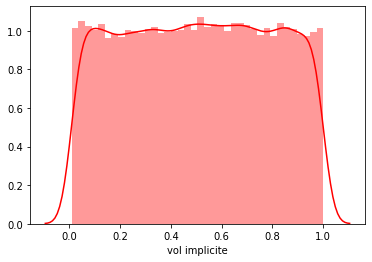

In [ ]:
#distribution de la vol implicite
import seaborn as sns
ax=sns.distplot(df['vol implicite'],hist=True,color='r',label='volatilité implicite')
ax

In [ ]:
from sklearn.model_selection import train_test_split
lm = LinearRegression()
X = df[['Stock price','Time to maturity','Risk free rate','Call price']]
Y = df['vol implicite']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1)
lm.fit(x_train,y_train)
lm.score(x_test,y_test)

0.44022506029988234

In [ ]:
Yhat=lm.predict(x_test)
Yhat

array([0.78259958, 0.23839699, 0.46492488, ..., 0.21944384, 0.55001756,
       0.59016653])

### Paramètres du modèle

In [ ]:
print('Intercept: \n', lm.intercept_)
print('Coefficients: \n', lm.coef_)

Intercept: 
 1.4928744644099456
Coefficients: 
 [-1.33113564 -0.25857059 -0.69140021  2.30620217]



### Parcelles résiduelles


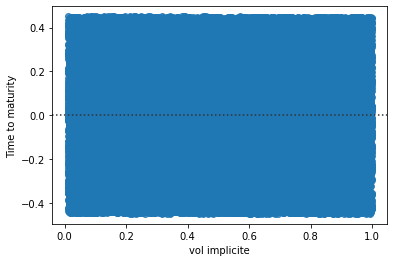

In [ ]:
import seaborn as sns
sns.residplot(y_train,x_train['Time to maturity'])

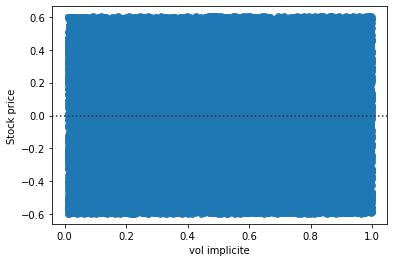

In [ ]:
import seaborn as sns
sns.residplot(y_train,x_train['Stock price'])

## ANN appliquée au modèle de Black & Scholes

### ANN BS Call price 

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split
X1 = df[['Stock price','Time to maturity','Risk free rate','vol implicite']]
Y1 = df['Call price']
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.1, random_state=1)

#### Création du réseau de neurones

In [ ]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(400,activation = 'relu',kernel_initializer='glorot_uniform')(input1)
x2=keras.layers.Dense(400,activation = 'relu')(x1) 
x3=keras.layers.Dense(400,activation = 'relu')(x2) 


x4=keras.layers.Dense(1,activation = 'linear')(x3)


modelBS = keras.models.Model(inputs=input1, outputs=x4)
modelBS.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 401       
Total params: 323,201
Trainable params: 323,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def root_mean_squared_error(x_true, x_pred):
        return K.sqrt(K.mean(K.square(x_pred - x_true)))
modelBS.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mse', 'mae', 'mape'])

historybs=modelBS.fit(X_train, Y_train, batch_size=1042,validation_data = (X_test,Y_test),epochs = 200, verbose = True,shuffle=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/200
45000/45000 [==============================] - 4s 94us/step - loss: 0.0938 - mse: 0.0113 - mae: 0.0752 - mape: 3840523.3639 - val_loss: 0.0343 - val_mse: 0.0012 - val_mae: 0.0263 - val_mape: 2165093.0808
Epoch 2/200
45000/45000 [==============================] - 4s 86us/step - loss: 0.0206 - mse: 4.8146e-04 - mae: 0.0161 - mape: 673725.4220 - val_loss: 0.0174 - val_mse: 3.0300e-04 - val_mae: 0.0144 - val_mape: 290175.7012
Epoch 3/200
45000/45000 [==============================] - 4s 87us/step - loss: 0.0147 - mse: 3.1337e-04 - mae: 0.0123 - mape: 258291.2069 - val_loss: 0.0422 - val_mse: 0.0018 - val_mae: 0.0389 - val_mape: 945925.9952
Epoch 4/200
45000/45000 [==============================] - 4s 86us/step - loss: 0.0314 - mse: 0.0012 - mae: 0.0269 - mape: 479151.0913 - val_loss: 0.0080 - val_mse: 6.4069e-05 - val_mae: 0.0067 - val_mape: 410784.8286
Epoch 5/200
45000/45000 [==============================] - 4s 86us/step - los

In [ ]:
Ypred=modelBS.predict(X_test)

In [ ]:
Ypred

array([[ 7.55521418e-01],
       [-5.67764151e-04],
       [ 3.78840098e-02],
       ...,
       [ 7.50598532e-01],
       [ 2.72703963e-02],
       [ 3.33433051e-03]])

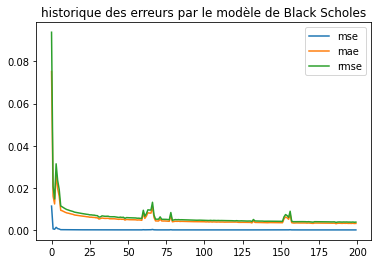

In [ ]:
from pandas import DataFrame
import matplotlib.pyplot as plt
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
g1, =plt.plot(historybs.history['mse'],label="mse")
g2, =plt.plot(historybs.history['mae'],label="mae")
g3, =plt.plot(historybs.history['loss'],label="rmse")
plt.legend(handles=[g1, g2, g3], labels=['mse', 'mae', 'rmse'])
plt.title('historique des erreurs par le modèle de Black Scholes')
plt.show()

In [ ]:
from pandas import DataFrame
residualsbs =np.zeros(len(Ypred))
Yval=Y_test.values
for i in range(len(Ypred)):
  residualsbs[i]= Yval[i]-Ypred[i,0] 

residualsbs = DataFrame(residualsbs)
print(residualsbs.describe())

                 0
count  5000.000000
mean     -0.003077
std       0.002617
min      -0.009157
25%      -0.005338
50%      -0.003187
75%      -0.000605
max       0.002976


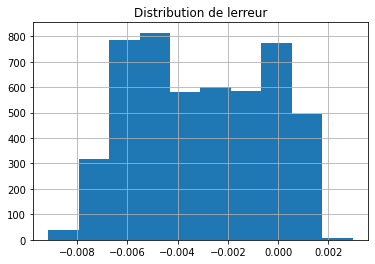

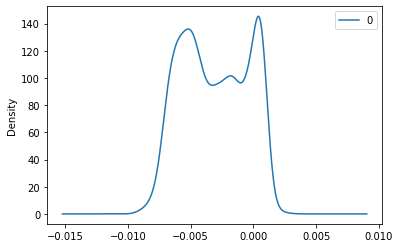

In [ ]:
import matplotlib.pyplot as plt
# histogram plot
residualsbs.hist()
plt.title('Distribution de l''erreur')

# density plot
residualsbs.plot(kind='kde')
plt.show()

### ANN-IV 

In [ ]:
from sklearn.model_selection import train_test_split
X2 = df[['Stock price','Time to maturity','Risk free rate','Call price']]
Y2 = df['vol implicite']
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X1, Y1, test_size=0.1, random_state=1)

In [ ]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(4,))
x1 = keras.layers.Dense(400,activation = 'relu',kernel_initializer='glorot_uniform')(input1)
x2=keras.layers.Dense(400,activation = 'relu')(x1) 
x3=keras.layers.Dense(400,activation = 'relu')(x2) 


x4=keras.layers.Dense(1,activation = 'linear')(x3)


modelBS_IV = keras.models.Model(inputs=input1, outputs=x4)
modelBS_IV.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               2000      
_________________________________________________________________
dense_6 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_7 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 401       
Total params: 323,201
Trainable params: 323,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def root_mean_squared_error(x_true, x_pred):
        return K.sqrt(K.mean(K.square(x_pred - x_true)))
modelBS_IV.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mse', 'mae', 'mape'])

historyiv=modelBS_IV.fit(X2_train, Y2_train, batch_size=1042,validation_data = (X2_test,Y2_test),epochs = 200, verbose = True,shuffle=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/200
45000/45000 [==============================] - 4s 86us/step - loss: 0.0938 - mse: 0.0113 - mae: 0.0755 - mape: 4136713.3840 - val_loss: 0.0467 - val_mse: 0.0022 - val_mae: 0.0367 - val_mape: 2947454.0813
Epoch 2/200
45000/45000 [==============================] - 4s 83us/step - loss: 0.0241 - mse: 6.8663e-04 - mae: 0.0191 - mape: 975976.6219 - val_loss: 0.0133 - val_mse: 1.7769e-04 - val_mae: 0.0102 - val_mape: 134047.8511
Epoch 3/200
45000/45000 [==============================] - 4s 84us/step - loss: 0.0218 - mse: 7.2579e-04 - mae: 0.0185 - mape: 240668.6102 - val_loss: 0.0227 - val_mse: 5.1465e-04 - val_mae: 0.0176 - val_mape: 164469.6228
Epoch 4/200
45000/45000 [==============================] - 4s 83us/step - loss: 0.0293 - mse: 9.5394e-04 - mae: 0.0246 - mape: 204288.7737 - val_loss: 0.0293 - val_mse: 8.6036e-04 - val_mae: 0.0259 - val_mape: 125511.3078
Epoch 5/200
45000/45000 [==============================] - 4s 84us/st

In [ ]:
IVpred=modelBS_IV.predict(X2_test)

In [ ]:
IVpred

array([[ 7.55883697e-01],
       [-7.40646806e-05],
       [ 3.91587307e-02],
       ...,
       [ 7.49056487e-01],
       [ 2.80884692e-02],
       [ 4.40432045e-03]])

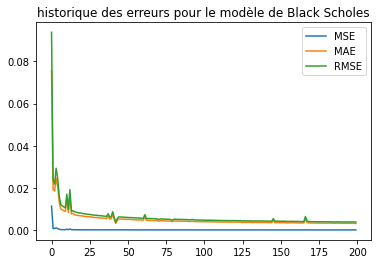

In [ ]:
from pandas import DataFrame
import matplotlib.pyplot as plt
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
p1, =plt.plot(historyiv.history['mse'],label="MSE")
p2, =plt.plot(historyiv.history['mae'],label="MAE")
p3, =plt.plot(historyiv.history['loss'],label="RMSE")
plt.legend(handles=[p1, p2, p3], labels=['MSE', 'MAE', 'RMSE'])
plt.title('historique des erreurs pour le modèle de Black Scholes')
plt.show()

In [ ]:
from pandas import DataFrame
residualsiv =np.zeros(len(Ypred))
Yval2=Y2_test.values
for i in range(len(Ypred)):
  residualsiv[i]= Yval2[i]-Ypred[i,0] 

residualsiv = DataFrame(residualsiv)
print(residualsiv.describe())

                 0
count  5000.000000
mean     -0.003077
std       0.002617
min      -0.009157
25%      -0.005338
50%      -0.003187
75%      -0.000605
max       0.002976


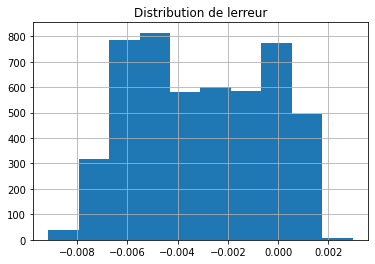

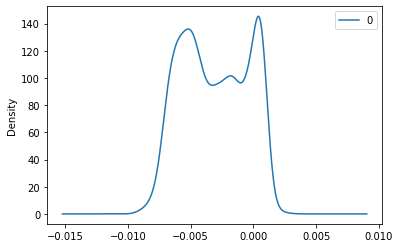

In [ ]:
 import matplotlib.pyplot as plt
# histogram plot
residualsbs.hist()
plt.title('Distribution de l''erreur')

# density plot
residualsbs.plot(kind='kde')
plt.show()

# Estimation du prix par le modèle de Heston

## Méthode de Fourier 

In [ ]:
import numpy as np
import scipy 
from numpy import meshgrid, sqrt, diff
from scipy import inf, pi, exp, linspace, zeros, real, imag, array, log
from scipy.stats import norm
from scipy.integrate import quad
import scipy.special as special
#from scipy.integrate import simps
import scipy.integrate as integrate


In [ ]:
def heston_phi(u,k,teta,sigma,ro,v0,s0,r,t):

    j=complex(0,1)
    gama=np.sqrt(sigma**2*(u**2 +j*u) + (k-j*ro*sigma*u)**2)
    a=np.exp(j*u*np.log(s0)+j*u*r*t+(k*teta*t*(k-j*ro*sigma*u)/sigma**2))
    b=(np.cosh(gama*t/2)+((k-j*ro*sigma*u)*np.sinh(gama*t/2)/gama) )**(2*k*teta/(sigma**2))
    c=np.exp(-(u**2+j*u)*v0/(gama*((1/np.tanh(gama*t/2)))+k-j*ro*sigma*u))
    return((a*c)/b)
    
b=heston_phi(2,2,0.04,0.5,-0.7,0.04,100,0.03,0.5)

def C(k,teta,sigma,ro,v0,s0,r,t,sup,K):
    #mu = np.arange(0,sup,0.1)
    j=complex(0,1)
    f=lambda  mu: np.real(heston_phi(mu-2*j,k,teta,sigma,ro,v0,s0,r,t)*np.exp(-j*mu*np.log(K))/((1+j*mu)*(2+j*mu)))
    #f=heston_phi(mu-2*j,k,teta,sigma,ro,v0,s0,r,t)*np.exp(-j*mu*np.log(K))/((1+j*mu)*(2+j*mu))
    y=integrate.quad(f,0,100)
    x=y[0]*np.exp(-r*t-np.log(K))/np.pi
    return(x)
    
a=C(2,0.04,0.5,-0.7,0.04,100,0.03,0.5,100,90)
a
 

13.202281465908618

### Courbe de volatilité implicite en fonction de la moneyness

In [ ]:
%matplotlib inline
import numpy as np
import random as rd  
import matplotlib.pyplot as plt
n=1000
K=np.zeros(n)
k=np.zeros(n)
IV=np.zeros(n)
C1=np.zeros(n)
#v=black_scholes_call_div(S, K, T, r,  sigma)
#sigma1=newton(g,gp,x0,0.001,1000,S,K,T,r,sigma,v)
#secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
K=np.linspace(80,300,num=n, endpoint=True)
for i in range(n):
    
    #k[i]=np.log(100/K[i])
    C1[i]= C(2,0.04,0.5,-0.7,0.04,100,0.03,0.5,100,K[i])
    #def secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    #brents(f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    IV[i]=brents(g,0.05,1,100,0.0000001,100,K[i],1,0.03,0.5,C1[i])[0]
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
# cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlabel('moneyness')
ax1.set_ylabel('Volatilité implicite')
plt.plot(np.log(K/100),IV)

plt.show()

## Méthode de Monte-Carlo

In [ ]:
import numpy as np
def heston(x,v,T,L,kappa,teta,sigma,r,rho):
    MU  = np.array([0, 0])
    COV = np.matrix([[1, rho], [rho, 1]])
    W   = np.random.multivariate_normal(MU, COV, L)
    W_1 = W[:,0]
    W_2 = W[:,1]
    for i in range(1,L):
        x=x+(r-v/2)*(T/L)+np.sqrt(max(0,v))*np.sqrt(T/L)* W_1[i-1]
        v=v+kappa*(teta-v)*(T/L)+sigma*np.sqrt(max(0,v))*np.sqrt(T/L)*W_2[i-1]
    return(v,x)
y=heston(4.6,0.04,0.5,100,2,0.04,0.5,0.03,-0.7)
print(y[0])
print(y[1])

0.09274392074848044
4.859862479815202


In [ ]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random as rd
def f(x,k):
    return(max(np.exp(x)-k,0))
def monte_carlo(T,L,kappa,teta,sigma,r,rho,K,N):
    s=0
    for i in range(N):
        s=s+f(heston(np.log(100),0.04,T,L,kappa,teta,sigma,r,rho)[1],K)
    return(np.exp(-r*T)*s/N)
c=monte_carlo(0.5,100,2,0.04,0.5,0.03,-0.7,90,1000)
print(c)


13.479214014731527


### Courbe de volatilité implicite en fonction de la moneyness

In [ ]:
%matplotlib inline
import numpy as np
import random as rd  
import matplotlib.pyplot as plt
n=1000
K=np.zeros(n)
k=np.zeros(n)
IV=np.zeros(n)
Call=np.zeros(n)
#v=black_scholes_call_div(S, K, T, r,  sigma)
#sigma1=newton(g,gp,x0,0.001,1000,S,K,T,r,sigma,v)
#secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
K=np.linspace(80,300,num=n, endpoint=True)
for i in range(n):
    
    #k[i]=np.log(100/K[i])
    Call[i]=monte_carlo(0.5,100,2,0.04,0.5,0.03,-0.7,K[i],10000)
    #def secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    #brents(f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    IV[i]=brents(g,0.05,1,100,0.0000001,100,K[i],1,0.03,0.5,Call[i])[0]
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
# cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlabel('moneyness')
ax1.set_ylabel('Volatilité implicite')
plt.plot(np.log(K/100),IV)

plt.show()


#### Lissage de la courbe de la volatilité implicite en fonction de la moneyness

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt
n=100
K=np.zeros(n)
k=np.zeros(n)
IV=np.zeros(n)
Call=np.zeros(n)
#v=black_scholes_call_div(S, K, T, r,  sigma)
#sigma1=newton(g,gp,x0,0.001,1000,S,K,T,r,sigma,v)
#secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
K=np.linspace(80,150,num=n, endpoint=True)
N=1000
for i in range(N):
    
    #k[i]=np.log(100/K[i])
    Call[i]=monte_carlo(0.5,100,2,0.04,0.5,0.03,-0.7,K[i],1000)
    #def secantmethod (f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    #brents(f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v):
    IV[i]=brents(g,0.05,1,100,0.0000001,100,K[i],1,0.03,0.5,Call[i])[0]
x,y=K,IV
# The third parameter specifies the type of the variable x;
# "c" stands for continuous
kr = KernelReg(y,x,"c")
plt.plot(x, y)
y_pred, y_std = kr.fit(x)
plt.plot(x, y_pred)
plt.show()

## Création de la base donnée

### output price 

In [ ]:
import numpy as np
import random as rd
n=50000
K=90
k=2
teta=0.04
sigma=0.5
ro=-0.7
v0=0.04
s0=100
Call_price=np.zeros(n)
Stock_price=np.zeros(n)
Time_to_maturity=np.zeros(n)
Risk_free_rate=np.zeros(n)
#sigma_imp=np.zeros(n)

for i in range(n):
  Stock_price[i]=rd.uniform(0.5, 1.4)
  Time_to_maturity[i]=rd.uniform(0.05, 1)
  Risk_free_rate[i]=rd.uniform(0.0, 0.1)
  #sigma_imp[i]=rd.uniform(0.01, 1)
  S=Stock_price[i]
  T=Time_to_maturity[i]
  R=Risk_free_rate[i]
  #sigma=sigma_imp[i]
  #V=C*K
  Call_price[i]= C(k,teta,sigma,ro,v0,s0,R,T,1000,K)
  


In [ ]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
L=[Stock_price,Time_to_maturity,Risk_free_rate,Call_price]
df_price=pd.DataFrame(L)
df_price=df_price.transpose()
df_price.columns=['Stock price','Time to maturity','Risk free rate','Call price']
df_price.tail()


,Stock price,Time to maturity,Risk free rate,Call price
49995,0.566665,0.825692,0.011463,13.876339
49996,0.658514,0.556173,0.092773,16.056530
49997,1.134942,0.223172,0.098120,12.609052
49998,0.712170,0.291995,0.012600,11.513543
49999,1.270616,0.978762,0.037534,16.176606


In [ ]:
df_price.isnull().sum().sum()
#df_price.isna()

0

## Modèle regression polynomiale

In [ ]:
from sklearn.model_selection import train_test_split 
x=df_price[['Stock price','Time to maturity','Risk free rate']]
y=df['Call price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import  PolynomialFeatures


In [ ]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2,include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)

In [ ]:
pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
ypipe=pipe.predict(x_test)
y_poly_pred=pipe.predict(x_train)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
r2 = r2_score(y_train,y_poly_pred)
print(rmse)
print(r2)

0.2180491893988959
0.00043221399568016405


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r_squared = r2_score(y_test, ypipe)
print('The R-square value is: ', r_squared)
print('mean squarred error is:',mean_squared_error(y_test, ypipe))

The R-square value is:  -0.0007222474038672821
mean squarred error is: 0.048229356189255106


## Modèle ANN/ Keras appliqué au modèle de Heston

### Création de la base de données

In [ ]:
import numpy as np
import random as rd
n=50000
#teta=0.04
K=1
Moneyness=np.zeros(n)
Time_to_maturity=np.zeros(n)
Risk_free_rate=np.zeros(n)
Correlation=np.zeros(n)
Reversion_speed=np.zeros(n)
Long_average_variance=np.zeros(n)
Volatility_of_volatility=np.zeros(n)
Initial_variance=np.zeros(n)
Call_price=np.zeros(n)

for i in range(n):
  Moneyness[i]=rd.uniform(0.6,1.4)
  Time_to_maturity[i]=rd.uniform(0.1,0.4)
  Risk_free_rate[i]=rd.uniform(0.0,0.01)
  Correlation[i]=rd.uniform(-0.95,0.0)
  Reversion_speed[i]=rd.uniform(0.0,2.0)
  Long_average_variance[i]=rd.uniform(0.0,0.5)
  Volatility_of_volatility[i]=rd.uniform(0,0.5)
  Initial_variance[i]=rd.uniform(0.0,0.5) 

  m=Moneyness[i]
  T=Time_to_maturity[i]
  r=Risk_free_rate[i]
  ro=Correlation[i]
  kappa=Reversion_speed[i]
  teta=Long_average_variance[i]
  sigma=Volatility_of_volatility[i]
  v0=Initial_variance[i]
  Call_price[i]= C(kappa,teta,sigma,ro,v0,m,r,T,1000,K)
# C(k,teta,sigma,ro,v0,s0,r,t,sup,K)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in cdouble_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in cdouble_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in cdouble_scalars
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in cdouble_scalars
  from ipykernel import kernelapp as app


In [ ]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
L1=[Initial_variance,Volatility_of_volatility,Time_to_maturity,Risk_free_rate,Moneyness,Correlation,Reversion_speed,Long_average_variance,Call_price]
df_NN=pd.DataFrame(L1)
df_NN=df_NN.transpose()
df_NN.columns=['Initial variance','Volatility of volatility','Time to maturity','Risk_free_rate','Moneyness','Correlation','Reversion speed','Long average variance','Call price']
df_NN.head()


,Initial variance,Volatility of volatility,Time to maturity,Risk_free_rate,Moneyness,Correlation,Reversion speed,Long average variance,Call price
0,0.323450,0.189283,0.211393,0.007634,0.785966,-0.650402,0.619191,0.195817,0.020221
1,0.465308,0.174459,0.257606,0.008860,0.620805,-0.671950,0.259575,0.202132,0.008804
2,0.280736,0.292805,0.373748,0.003989,0.604218,-0.314118,0.410396,0.116084,0.004824
3,0.388740,0.088013,0.279875,0.006973,0.660384,-0.400848,0.577643,0.365203,0.012772
4,0.278494,0.481429,0.210724,0.002412,1.235555,-0.017086,1.725157,0.055145,0.259521


In [ ]:
df_NN.isnull().sum().sum()
#df_NN.isna()

894

In [ ]:
df_NN.dropna()

,Initial variance,Volatility of volatility,Time to maturity,Risk_free_rate,Moneyness,Correlation,Reversion speed,Long average variance,Call price
0,0.323450,0.189283,0.211393,0.007634,0.785966,-0.650402,0.619191,0.195817,0.020221
1,0.465308,0.174459,0.257606,0.008860,0.620805,-0.671950,0.259575,0.202132,0.008804
2,0.280736,0.292805,0.373748,0.003989,0.604218,-0.314118,0.410396,0.116084,0.004824
3,0.388740,0.088013,0.279875,0.006973,0.660384,-0.400848,0.577643,0.365203,0.012772
4,0.278494,0.481429,0.210724,0.002412,1.235555,-0.017086,1.725157,0.055145,0.259521
...,...,...,...,...,...,...,...,...,...
49995,0.470166,0.346924,0.234637,0.002557,0.953135,-0.506921,0.181301,0.319947,0.105019
49996,0.296617,0.332909,0.350759,0.007032,1.211300,-0.505798,1.317877,0.001684,0.263108
49997,0.422027,0.257652,0.205424,0.004099,1.292693,-0.246667,1.489188,0.449843,0.329524
49998,0.008133,0.161913,0.341532,0.000990,1.221317,-0.565738,0.483952,0.111351,0.222114


In [ ]:
df_NN1 = df_NN.apply (pd.to_numeric, errors='coerce')
df_NN1 = df_NN1.dropna()

print (df_NN1)

       Initial variance  ...  Call price
0              0.323450  ...    0.020221
1              0.465308  ...    0.008804
2              0.280736  ...    0.004824
3              0.388740  ...    0.012772
4              0.278494  ...    0.259521
...                 ...  ...         ...
49995          0.470166  ...    0.105019
49996          0.296617  ...    0.263108
49997          0.422027  ...    0.329524
49998          0.008133  ...    0.222114
49999          0.201800  ...    0.140499

[49106 rows x 9 columns]


In [ ]:
df_NN1.isnull().sum().sum()

0

### Application du modèle pour le prix du call

In [ ]:
# first neural network with keras tutorial
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
#training data
from sklearn.model_selection import train_test_split 
x=df_NN1[['Initial variance','Volatility of volatility','Time to maturity','Risk_free_rate','Moneyness','Correlation','Reversion speed','Long average variance','Call price']].values
y=df_NN1['Call price'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale2=  StandardScaler()
y_train1= y_train.reshape(-1, 1)
y_test1=y_test.reshape(-1,1)
x_train_transform = scale.fit_transform(x_train)
x_test_transform = scale.transform(x_test)
y_train_transform = scale2.fit_transform(y_train1)
y_test_transform = scale2.transform(y_test1)


In [ ]:
np.shape(y_train1)

(44195, 1)

### Creation Du réseau de neurones

In [ ]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(9,))
x1 = keras.layers.Dense(400,activation = 'relu',kernel_initializer='glorot_uniform')(input1)
x2=keras.layers.Dense(400,activation = 'relu')(x1) 
x3=keras.layers.Dense(400,activation = 'relu')(x2) 


x4=keras.layers.Dense(1,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4000      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 401       
Total params: 325,201
Trainable params: 325,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def root_mean_squared_error(x_true, x_pred):
        return K.sqrt(K.mean(K.square(x_pred - x_true)))
modelGEN.compile(loss=root_mean_squared_error, optimizer='adam', metrics=['mse', 'mae', 'mape'])

history=modelGEN.fit(x_train_transform, y_train_transform, batch_size=1042,validation_data = (x_test_transform,y_test_transform),epochs = 200, verbose = True,shuffle=1)

Train on 44195 samples, validate on 4911 samples
Epoch 1/200
44195/44195 [==============================] - 4s 86us/step - loss: 0.1377 - mse: 0.0505 - mae: 0.1134 - mape: 34.9418 - val_loss: 0.0390 - val_mse: 0.0015 - val_mae: 0.0323 - val_mape: 19.5694
Epoch 2/200
44195/44195 [==============================] - 4s 80us/step - loss: 0.0295 - mse: 8.9229e-04 - mae: 0.0239 - mape: 15.0425 - val_loss: 0.0253 - val_mse: 6.4051e-04 - val_mae: 0.0202 - val_mape: 13.0835
Epoch 3/200
44195/44195 [==============================] - 4s 80us/step - loss: 0.0232 - mse: 5.4164e-04 - mae: 0.0188 - mape: 10.4920 - val_loss: 0.0228 - val_mse: 5.1902e-04 - val_mae: 0.0187 - val_mape: 13.7795
Epoch 4/200
44195/44195 [==============================] - 4s 80us/step - loss: 0.0199 - mse: 4.0794e-04 - mae: 0.0162 - mape: 10.7809 - val_loss: 0.0288 - val_mse: 8.2815e-04 - val_mae: 0.0251 - val_mape: 16.0385
Epoch 5/200
44195/44195 [==============================] - 4s 80us/step - loss: 0.0193 - mse: 3.9662e-0

In [ ]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]


def xinversetransform(x):
    return scale2.inverse_transform(x)

In [ ]:
Yhat=xinversetransform(modelGEN.predict(x_test_transform))

In [ ]:
Yhat

array([[0.11653931],
       [0.34972335],
       [0.01188809],
       ...,
       [0.40235832],
       [0.06647118],
       [0.16088039]])

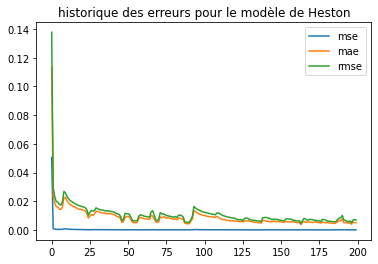

In [ ]:
from pandas import DataFrame
import matplotlib.pyplot as plt
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
pp1, =plt.plot(history.history['mse'],label="mse")
pp2, =plt.plot(history.history['mae'],label="mae")
pp3, =plt.plot(history.history['loss'],label="rmse")
plt.legend(handles=[pp1,pp2,pp3], labels=['mse', 'mae', 'rmse'])
plt.title('historique des erreurs pour le modèle de Heston')
plt.show()

In [ ]:
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
residuals = [y_test[i]-Yhat[i] for i in range(len(Yhat))]
residuals = DataFrame(residuals)
print(residuals.describe())

                 0
count  4911.000000
mean     -0.000678
std       0.000918
min      -0.003454
25%      -0.001270
50%      -0.000352
75%       0.000002
max       0.001571


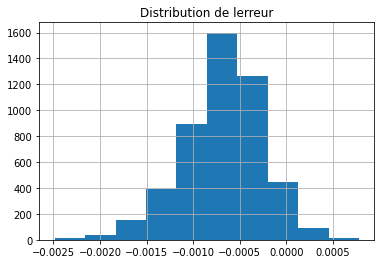

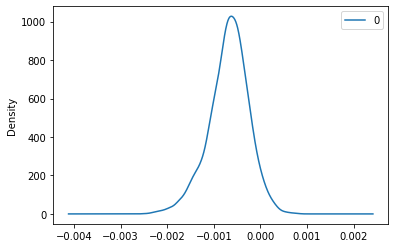

In [ ]:

# histogram plot
residuals.hist()
plt.title('Distribution de l''erreur')
pyplot.show()
# density plot
residuals.plot(kind='kde')
pyplot.show()

### Application du modèle pour la volatilité implicite

In [ ]:
len(Yhat)

4909

In [ ]:

sigma_IV=np.zeros(len(Yhat))
S=np.zeros(len(Yhat))
T=np.zeros(len(Yhat))
K=np.zeros(len(Yhat))
r=np.zeros(len(Yhat))
m=np.zeros(len(Yhat))
sigma=np.zeros(len(Yhat))
v=np.zeros(len(Yhat))
n=len(df_NN1)
for i in range(len(Yhat)):
  m[i]=df_NN1['Moneyness'].values[i+len(df_NN1)-len(Yhat)]
  T[i]=df_NN1['Time to maturity'].values[i+len(df_NN1)-len(Yhat)]
  S[i]=100
  K[i]=100*df_NN1['Moneyness'].values[i+len(df_NN1)-len(Yhat)]
  r[i]=df_NN1['Risk_free_rate'].values[i+len(df_NN1)-len(Yhat)]
  sigma[i]=df_NN1['Volatility of volatility'].values[i+len(df_NN1)-len(Yhat)]
  v[i]=Yhat[i]
  # brents(f,x0,x1,max_iter,tolerance,S,K,T,r,sigma,v)
  sigma_IV[i]=brents(g,0.05,1,10000,0.000000001,S[i],K[i],T[i],r[i],sigma[i],v[i])[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
sigma_IV

array([0.05      , 0.3802755 , 0.10855339, ..., 0.34946588, 0.162137  ,
       0.1861534 ])

In [ ]:
import pandas as pd 
from sklearn.linear_model import LinearRegression
L2=[T,S,K,m,r,sigma,v,sigma_IV]
df_new=pd.DataFrame(L2)
df_new=df_new.transpose()
df_new.columns=['Time to maturity','Stock price','Strike','Moneyness','Risk_free_rate','sigma','Call price','Implied volatility']
df_new.head()


,Time to maturity,Stock price,Strike,Moneyness,Risk_free_rate,sigma,Call price,Implied volatility
0,0.325263,100.0,89.633552,0.896336,0.000006,0.478914,0.116539,0.050000
1,0.203428,100.0,134.272343,1.342723,0.003117,0.319973,0.349723,0.380276
2,0.340877,100.0,117.551400,1.175514,0.000826,0.049874,0.011888,0.108553
3,0.171383,100.0,116.120838,1.161208,0.000334,0.132466,0.017859,0.149986
4,0.346464,100.0,136.507344,1.365073,0.001882,0.395777,0.223088,0.280441


### La surface de volatilié en fonction de la moneyness

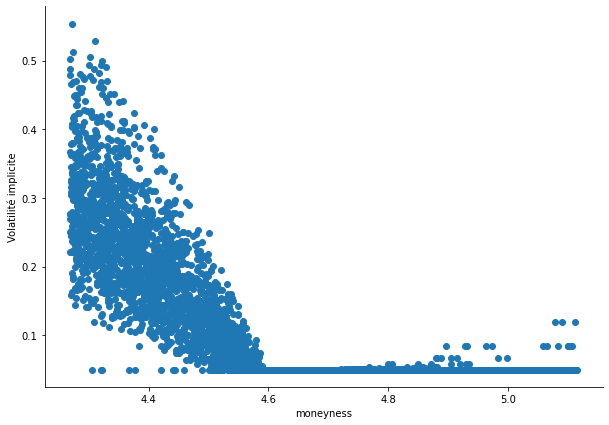

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
# cacher les cadres : haut et droit
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlabel('moneyness')
ax1.set_ylabel('Volatilité implicite')

plt.scatter(np.log(100/df_new['Moneyness']), df_new['Implied volatility'])

plt.show()

### La surface de volatilié en fonction des dates de maturité et de la moneyness

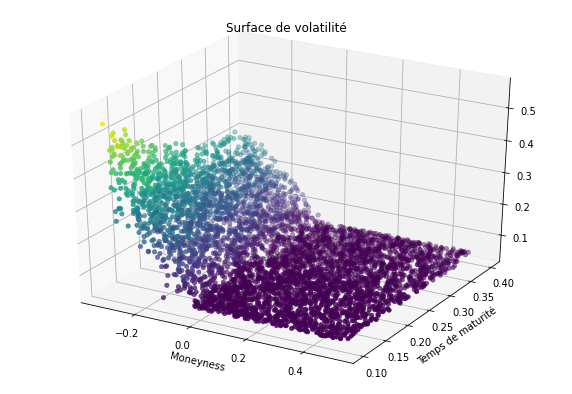

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
X3=df_new['Strike']
Y3=df_new['Time to maturity']
Z3=df_new['Implied volatility']

fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')
fig = plt.figure()
ax.set_xlabel('Moneyness')
ax.set_ylabel('Temps de maturité')
ax.set_title('Surface de volatilité')
ax.scatter(np.log(100/X3), Y3, Z3, c=Z3, cmap='viridis', linewidth=0.5)
